In [1]:
!pip install opencv-python

     |████████████████████████████████| 50.4 MB 12.3 MB/s eta 0:00:01


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

import random
import matplotlib.pyplot as plt
import cv2

In [17]:
def denormalise(values):
    y_den = []
    for dist in values:
        y_den.append(np.argmax(dist))
    
    return y_den

def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])
            
def read_data(path, tag2idx, im_size=(128,128)):
    X = []
    y = []
    for im_file in tqdm(glob(path)):
        try:
            label = im_file.split("/")[1]
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
            y.append(tag2idx[label])
        except Exception as e:
            print(e)
    
    X = np.array(X)
    y = np.array(to_categorical(y))
    return X, y

In [18]:
# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience, lr_factor):
    return [
        ModelCheckpoint(filepath= weights_file,
                        monitor="val_accuracy",
                        mode="max",
                        save_best_only=True, 
                        save_weights_only=True),
        EarlyStopping(monitor="val_accuracy",
                      mode="max",
                      patience = patience,
                      verbose=1),
        ReduceLROnPlateau(monitor="val_loss", mode="min",
                          factor=lr_factor, min_lr=1e-6)]

In [19]:
INPUT_SHAPE = (128, 128, 3)
IM_SIZE = (128, 128)
EPOCHS = 50
BATCH_SIZE = 48
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
RANDOM_STATE = 2020
WEIGHTS_FILE = "weights.h5"

In [20]:
path = 'eden_data/'
tag2idx = {tag:i for i, tag in enumerate(os.listdir(path))}
path = 'eden_data/*/*'
X, y = read_data(path, tag2idx, IM_SIZE)

 37%|███▋      | 62/168 [00:09<00:12,  8.48it/s]

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 168/168 [00:25<00:00,  6.68it/s]


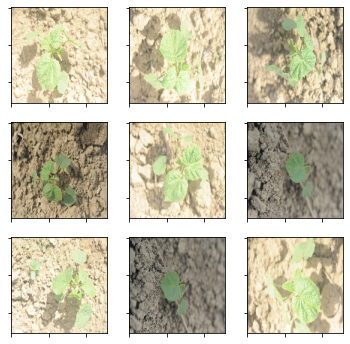

In [21]:
plot_sample(X[:50])

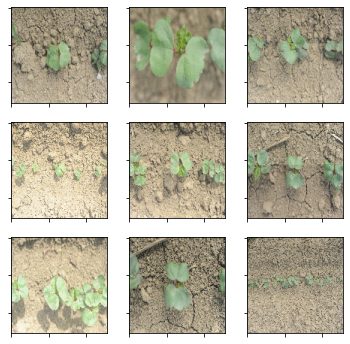

In [22]:
plot_sample(X[-50:])

In [23]:
def get_architecture(y):
    feature_extractor = Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False, # Do not include the ImageNet classifier at the top.
        input_shape=INPUT_SHAPE)  

    # Freeze the base_model
    feature_extractor.trainable = False

    # Create new model on top
    x = Flatten(name="flatten")(feature_extractor.output)
    x = Dense(units=100, activation="relu")(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    out = Dense(units=y.shape[1], 
                activation="softmax")(x)
    model = Model(feature_extractor.input, out)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    return model

In [24]:
def get_architecture(y):
    feature_extractor = Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False, # Do not include the ImageNet classifier at the top.
        input_shape=INPUT_SHAPE)  

    # Freeze the base_model
    feature_extractor.trainable = False

    # Create new model on top
    x = Flatten(name="flatten")(feature_extractor.output)
    x = Dense(units=100, activation="relu")(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    out = Dense(units=y.shape[1], 
                activation="softmax")(x)
    model = Model(feature_extractor.input, out)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    return model

In [25]:
model = get_architecture(y)

In [26]:
X_prep = preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(X_prep, y,
                                                    test_size=TEST_SPLIT, 
                                                    random_state = RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=VAL_SPLIT, 
                                                    random_state = RANDOM_STATE)

In [27]:
%%time
model.fit(X_train, 
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_val, y_val),
          callbacks=get_callbacks(WEIGHTS_FILE, 
                                  EPOCHS//5, 
                                  0.25))

Epoch 1/50
3/3 [==============================] - 3s 602ms/step - loss: 0.7532 - accuracy: 0.7291 - val_loss: 1.4641 - val_accuracy: 0.6818
Epoch 2/50
3/3 [==============================] - 1s 346ms/step - loss: 0.3940 - accuracy: 0.8751 - val_loss: 0.7677 - val_accuracy: 0.7727
Epoch 3/50
3/3 [==============================] - 1s 352ms/step - loss: 0.5460 - accuracy: 0.8468 - val_loss: 0.0510 - val_accuracy: 0.9545
Epoch 4/50
3/3 [==============================] - 1s 361ms/step - loss: 0.2293 - accuracy: 0.9676 - val_loss: 0.1581 - val_accuracy: 0.9091
Epoch 5/50
3/3 [==============================] - 1s 356ms/step - loss: 0.1808 - accuracy: 0.9812 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 1s 347ms/step - loss: 0.0191 - accuracy: 0.9932 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 1s 351ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/50
3/3 [====

In [29]:
model.load_weights(WEIGHTS_FILE)
f1_score(denormalise(y_test), 
         denormalise(model.predict(X_test)),
         average='micro')

1.0

In [31]:
import time
ts = int(time.time())

model.save(filepath=f'/home/jovyan/projectDir/eden_classifier/cotton_model/{ts}', save_format='tf')

INFO:tensorflow:Assets written to: /home/jovyan/projectDir/eden_classifier/cotton_model/1616543783/assets
